In [1]:
## custom
import utils, vis
import criteria as C


## third party
import networkx as nx
import poly_point_isect as bo   ##bentley-ottmann sweep line

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## generate a graph

In [2]:
# %%time

# for src, dist in nx.all_pairs_shortest_path_length(G):
#     print(src)
#     print(dist)
#     break

generating graph of 450 nodes
Calculating all pairs shortest path...


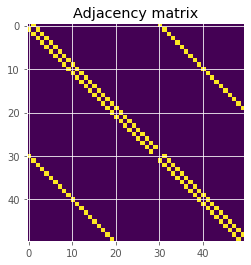

CPU times: user 2.43 s, sys: 24 ms, total: 2.45 s
Wall time: 2.47 s


In [3]:
%%time

print('generating graph', end=' ')
G = nx.grid_2d_graph(15,30)
print(f'of {len(G.nodes)} nodes')

print('Calculating all pairs shortest path...')
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}

W = 1/(D+1e-6)**2
truth = adj + torch.eye(adj.shape[0], device=device)

plt.imshow(adj[:50,:50])
plt.title('Adjacency matrix')
plt.show()

## Optimize via Stochastic Gradient Descent (SGD)

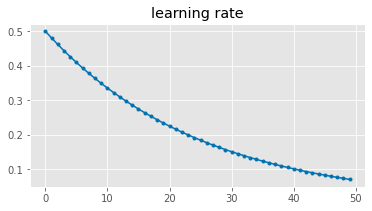

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
# delete old
!rm -r fig
!mkdir fig

niter = 10000

def getLR(i):
    base_lr = 0.5
    return np.exp(-i*2/niter) * base_lr


pos = torch.rand(len(G.nodes), 2, device=device)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=0.5, momentum=0.9, nesterov=True)
# optimizer = optim.Adam([pos], lr=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, getLR)


lrs = [getLR(i) for i in range(0,niter,niter//50)]
plt.figure(figsize=[6,3])
plt.plot(lrs, '.-')
plt.title('learning rate')
plt.show()

iterBar = tqdm(range(niter))
lossHistory = []
totalTime = 0


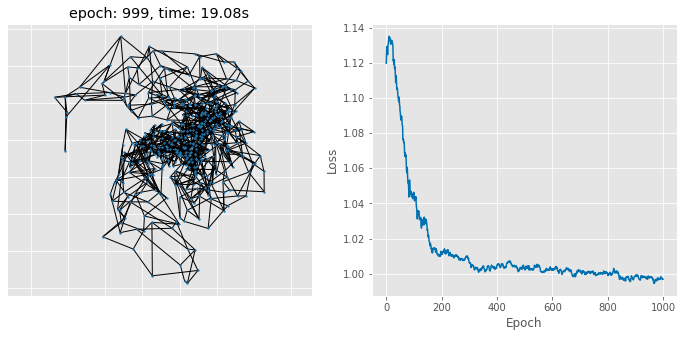

In [ ]:
VIS = True
gClamp = 0.1
sampleSize = len(G)
degrees = adj.sum(1).numpy().astype(np.int64)

for i in iterBar:
    
    t0 = time.time()
    optimizer.zero_grad()
    
    loss = 1 * C.neighborhood_preseration(pos, G, adj, k2i, i2k)
#     loss += 0.0001 * C.stress(pos, D, W, sampleSize)
#     loss += 0.001 * C.edge_uniformity(pos, G, k2i, sampleSize)
#     ## TODO: do the following efficiently and stochastically
#     loss += 0.5 * C.crossing_angle_maximization(pos, G, k2i, sampleSize)
#     loss += 0.5 * C.neighborhood_preservation(pos, G, k2i, sampleSize)
#     loss += 0.5 * C.crossings(pos, G, k2i, sampleSize)
#     loss += 0.5 * C.aspect_ratio(pos, G, k2i, sampleSize)
#     loss += 0.5 * C.angular_resolution(pos, G, k2i, sampleSize)
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    if scheduler is not None:
        scheduler.step()
    
    
    ##debug info
    dt = time.time() - t0
    totalTime += dt
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item()})
    if len(lossHistory)>0:
        lossHistory.append(0.9*lossHistory[-1] + 0.1*loss.item())
    else:
        lossHistory.append(loss.item())
    
    ##vis
    if VIS and i % int(niter/40) == int(niter/40)-1:
        iterBar.set_postfix({
            'loss': loss.item(),
#             'eu': f'{eu.item():.2e}',
#             'st': f'{st.item():.2e}',
        })
        
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)


In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)